

![GitHub](https://img.shields.io/github/license/probml/pyprobml)

Authors: Kevin P. Murphy (murphyk@gmail.com) and Mahmoud Soliman (mjs@aucegypt.edu)


In this notebook we will explore how to use XGBoost and sklearn's random forests to evaluate feature importance.

**XGBoost**

Support for the following features:
1. Vanilla Gradient Boosting algorithm (also known as GBDT (Grandient boosted decisin trees) or GBM(gradient boosting machine) with support to tuning [parameters](https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster), parallization and GPU support.
2. Stochastic Gradient Boosting with sampling with uniform and gradient-based sampling support as well as sub-sampling at the row, column and column per split levels.
3. Regularized Gradient Boosting with support to both L1 and L2 regularization(via alpha and lamda parameters respectively).
4. Dropout-esque behaviour via DART booster.

Note that we are using the SKLearn-like api of XGBoost for simplicity.

**SKLearn**

supports several features for ensemble learning one of which is Random forests, which uses bagging of decision tree classifiers (weak learners) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting


In [ ]:
# Attribution
# This notebook is based on the following:
# https://www.kaggle.com/kevalm/xgboost-implementation-on-iris-dataset-python
# https://xgboost.readthedocs.io/en/latest/tutorials/index.html
# https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20continuous%20and%20categorical%20features.html
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
# https://github.com/slundberg/shap/blob/master/notebooks/kernel_explainer/Iris%20classification%20with%20scikit-learn.ipynb

#Setup


In [2]:
# Imports

import os
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import train_test_split

In [3]:
# Install the extra required packages if any
!pip install lime -qq
import lime
import lime.lime_tabular as ll

!pip install shap -qq
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 35.6 MB/s eta 0:00:00


# Iris dataset


In [4]:
# loading the dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [5]:
# Splitting data into 80/20 training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Exploring boosting with xgboost

In [ ]:
# @title XGBClassifier

In [6]:
xgbc = XGBClassifier()
xgbc

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [7]:
# Training the classifier
xgbc.fit(X_train, y_train)
# Inferencing on testing data
xgbc_y_pred = xgbc.predict(X_test)
# Measuring accuracy
xgbc_acc = metrics.accuracy_score(y_test, xgbc_y_pred)
print("XGBClassifier accuracy is " + str(xgbc_acc))

XGBClassifier accuracy is 1.0


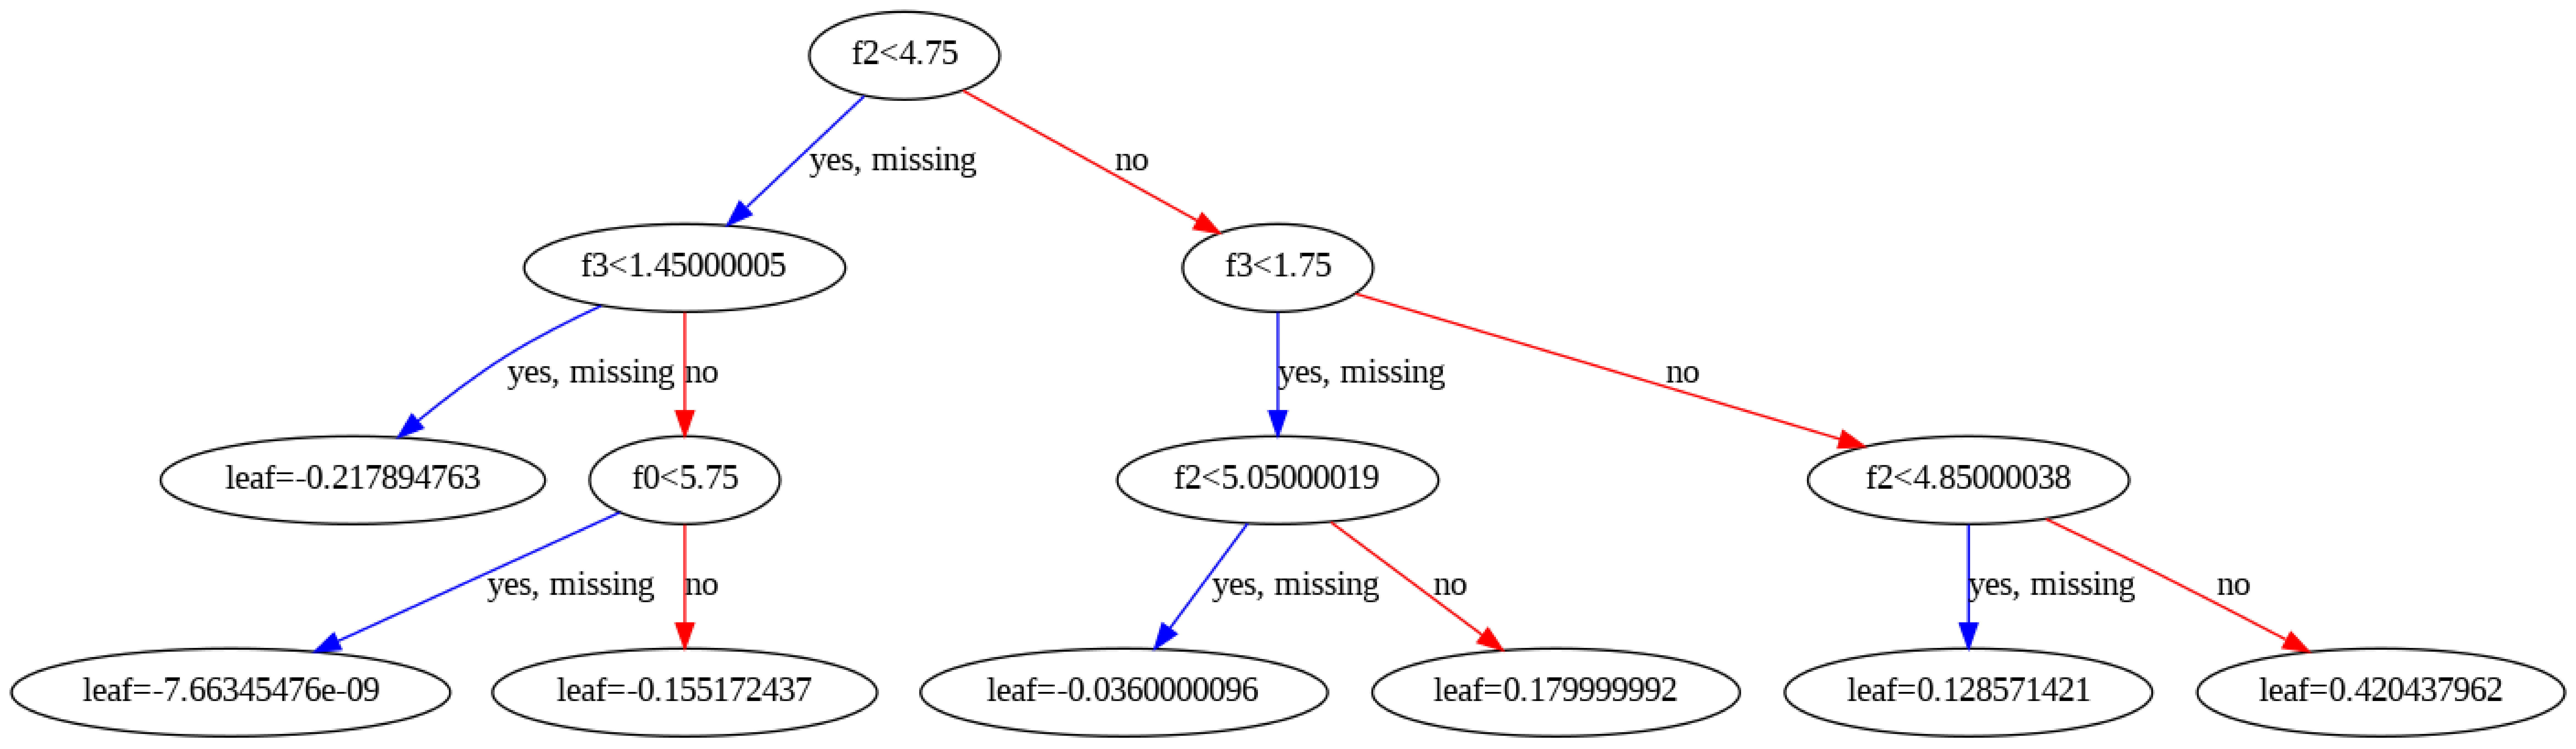

In [8]:
# @title Visualization of boosted tree
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

xgb.plot_tree(xgbc, num_trees=2)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig("treeIris.png")

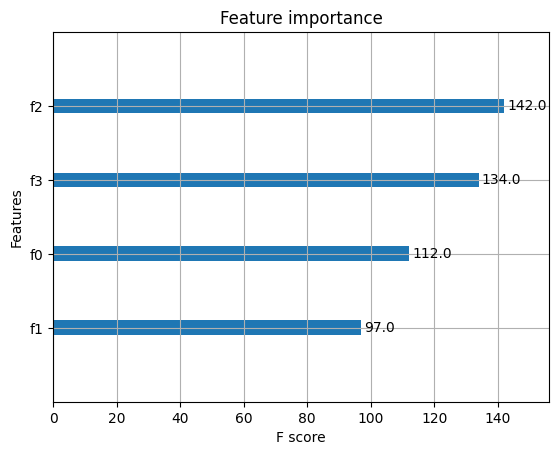

In [9]:
# @title Feature importance of XGBClassifier

plot_importance(xgbc)
pyplot.show()

# f1 - sepal length in cm
# f2 - sepal width in cm
# f3 - petal length in cm
# f4 - petal width in cm

In [ ]:
# @title Explanation of a sample of testing data of XGBClassifier via LIME
xgbc_lime_explainer = ll.LimeTabularExplainer(
    X_train, feature_names=iris.feature_names, class_names=iris.target_names, discretize_continuous=True
)
xgbc_i = np.random.randint(0, X_test.shape[0])
xgbc_exp = xgbc_lime_explainer.explain_instance(X_test[xgbc_i], xgbc.predict_proba, num_features=2, top_labels=1)
xgbc_exp.show_in_notebook(show_table=True, show_all=False)

In [ ]:
# @title Explanation of testing data of XGBClassifier via SHAP
shap.initjs()
# explain all the predictions in the test set
xgbc_shap_explainer = shap.KernelExplainer(
    xgbc.predict_proba, X_train, model_output="probability", feature_perturbation="interventional"
)
xgbc_shap_values = xgbc_shap_explainer.shap_values(X_test)
shap.force_plot(xgbc_shap_explainer.expected_value[0], xgbc_shap_values[0], X_test)

Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


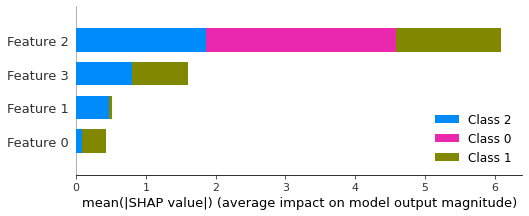

In [ ]:
xgbc_shap_explainer_2 = shap.TreeExplainer(xgbc)
xgbc_shap_values_2 = xgbc_shap_explainer_2.shap_values(X_test)
shap.summary_plot(xgbc_shap_values_2, X_test)

# Exploring bagging (Random Forests) with sklearn

In [ ]:
# @title RandomForestClassifier

In [ ]:
skrfc = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)
skrfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
skrfc_y_pred = skrfc.predict(X_test)
skrfc_acc = metrics.accuracy_score(y_test, skrfc_y_pred)
print("RandomForestClassifier accuracy is " + str(skrfc_acc))

RandomForestClassifier accuracy is 1.0


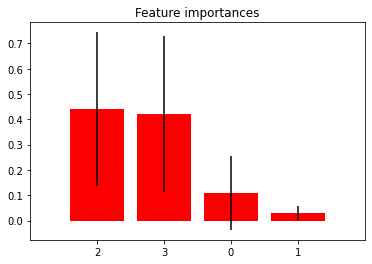

In [ ]:
# @title Feature importance of RandomForestClassifier
importances = skrfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in skrfc.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
# @title Explanation of a sample of testing data of RandomForestClassifier via LIME
skrfc_lime_explainer = ll.LimeTabularExplainer(
    X_train, feature_names=iris.feature_names, class_names=iris.target_names, discretize_continuous=True
)
skrfc_i = np.random.randint(0, X_test.shape[0])
skrfc_exp = skrfc_lime_explainer.explain_instance(X_test[xgbc_i], skrfc.predict_proba, num_features=2, top_labels=1)
skrfc_exp.show_in_notebook(show_table=True, show_all=False)

In [ ]:
# @title Explanation of testing data of RandomForestClassifier via SHAP
shap.initjs()
# explain all the predictions in the test set
skrfc_shap_explainer = shap.KernelExplainer(
    skrfc.predict_proba, X_train, model_output="probability", feature_perturbation="interventional"
)
skrfc_shap_values = skrfc_shap_explainer.shap_values(X_test)
shap.force_plot(skrfc_shap_explainer.expected_value[0], skrfc_shap_values[0], X_test)

Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


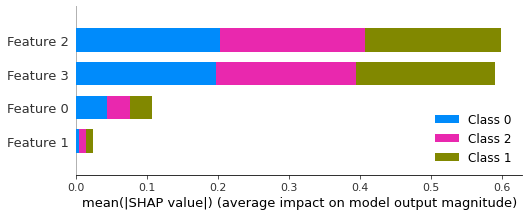

In [ ]:
skrfc_shap_explainer_2 = shap.TreeExplainer(skrfc)
skrfc_shap_values_2 = skrfc_shap_explainer_2.shap_values(X_test)
shap.summary_plot(skrfc_shap_values_2, X_test)